In [1]:
#Data processing
import pandas as pd
import regex as re
from unidecode import unidecode

#NLP

import nltk
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from collections import Counter



#Sentiment analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import sklearn
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib as plt


#Topic Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from bertopic import BERTopic

#Custom class
from sw import Sw





C:\Users\theod\Documents\Git\PE-x-DTIP\dtip2_env\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\theod\Documents\Git\PE-x-DTIP\dtip2_env\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\theod\Documents\Git\PE-x-DTIP\dtip2_env\lib\site-packag

In [2]:
import pandas as pd
#After some processing we can directly open some generated csv

dtype_options = {'Tags métier typologie  3': str, 'Evaluation  réponse structure 3 par auteur': str}
df = pd.read_csv("export-experiences-clean.csv", delimiter=';', encoding='iso-8859-1', dtype=dtype_options)
#df.info()

#Csv files used for the Sentiment analysis
bal_df=pd.read_csv("balanced_dataset.csv")


#Csv file to study the case of Gendarmerie Nationale in the Topic Modelling
str_df=pd.read_csv("export-structures.csv",delimiter=';',encoding='utf-8')

#Resulting file from the scrapping

scrap_df=pd.read_csv("commentaires.csv",delimiter=';',encoding="iso-8859-1")
scrap_df.info()

C:\Users\theod\AppData\Local\Temp\ipykernel_8288\3738070429.py:5: DtypeWarning: Columns (42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("export-experiences-clean.csv", delimiter=';', encoding='iso-8859-1', dtype=dtype_options)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Index        295 non-null    int64 
 1   Adresse      295 non-null    object
 2   Auteur       295 non-null    object
 3   Date         295 non-null    object
 4   Note         295 non-null    int64 
 5   Commentaire  73 non-null     object
dtypes: int64(2), object(4)
memory usage: 14.0+ KB


In [3]:
#Useful methods

#Sentiment analysis to predict class
def apply_model(column):
    tokens=tokenizer.encode_plus(column,add_special_tokens=True,padding=True,truncation=True, return_tensors="pt")
    outputs=model(**tokens)
    logits=outputs.logits
    predicted_class=logits.argmax().item()
    print(predicted_class)
    return(predicted_class)   


def filtrer_mots(texte):
    mots_filtrés = [mot for mot in texte.split() if len(mot) >= 3]
    return ' '.join(mots_filtrés)


def text_processing(data,column_name):
    data['desc']=data[column_name].apply(lambda x : re.sub(r'[^a-zA-Z]\s',' ', x))
    data['desc']=data['desc'].apply(lambda x: x.lower())
    data['desc']=data['desc'].apply(lambda x: re.sub(r'\d+',' ',x))
    data['desc']=data['desc'].str.replace('\W', ' ', regex=True)
    data['desc']=data['desc'].map(lambda x: unidecode(x))    
    data['desc']=data['desc'].apply(lambda x: filtrer_mots(x))   
      
    
    
def token_processing(data,stoplist,stop_list_stemming=[],verbose=False,nb_occurence=1):
    #Tokenisation
    token_df=pd.DataFrame(data["desc"])
    token_df["desc_token"]= token_df["desc"].apply(lambda x: nltk.word_tokenize(x))   
    
    #Removing useless words           
    token_df["desc_stop"]= token_df["desc_token"].apply(lambda x: [item for item in x if item not in stoplist])
    
    #Stemming
    sstem=SnowballStemmer(language='french')
    token_df["desc_stem"]=token_df["desc_stop"].apply(lambda row:[sstem.stem(word) for word in row])     
        
    corpus_texte = ' '.join(token_df["desc_stem"].map(lambda x: ' '.join(x)).tolist())
    compteur_mots = Counter(corpus_texte.split())
    mots_uniques = set([mot for mot, occurence in compteur_mots.items() if occurence <=nb_occurence]) 
    
    token_df["desc_stem+"]=token_df["desc_stem"].apply(lambda x: [item for item in x if item not in mots_uniques])
    
    #Filtering the stemming words
    token_df["desc_stem++"]=token_df["desc_stem+"].apply(lambda x: [item for item in x if item not in stop_list_stemming])
   
    #TfIdfVectorizer
    vectorizer = TfidfVectorizer() 
    data["desc_clean"]=token_df["desc_stem++"].apply(lambda x: " ".join(x))
    X = vectorizer.fit_transform(data["desc_clean"])
   
    if(verbose):
        #print(vectorizer.vocabulary_)        
        print("################################################################")
        print_word_counter(data)
    
    return token_df,X


#Method for Topic Modeling 

#Not Really used
def find_best_LDA(token_data,iterable=range(5,12)):
    for i in iterable:
        
        corpus=token_data["desc_stem+"].tolist()
        dictionary=Dictionary(corpus)
        bow_corpus=[dictionary.doc2bow(doc) for doc in corpus]
        lda_model=LdaModel(bow_corpus,num_topics=i, id2word=dictionary,passes=10)
        
        
        coherence_model_cv=CoherenceModel(model=lda_model,texts=corpus,dictionary=dictionary,coherence='c_v')
        coherence_score_cv=coherence_model_cv.get_coherence()

        coherence_model_umass = CoherenceModel(model=lda_model, texts=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_score_umass = coherence_model_umass.get_coherence()

        coherence_model_cnpmi = CoherenceModel(model=lda_model, texts=corpus, dictionary=dictionary, coherence='c_npmi')
        coherence_score_cnpmi = coherence_model_cnpmi.get_coherence()
               
        print(f"For {i} components, the coherence score_cv is: {coherence_score_cv}")
        print(f"For {i} components, the coherence score_umass is: {coherence_score_umass}")
        print(f"For {i} components, the coherence score_cnpmi is: {coherence_score_cnpmi}\n\n")

#Utilisation de BerTopic

def print_word_counter(data):
    if "desc_clean" not in data.columns:
        print("you can't use this method before token_processing")
        return
    data_list=data["desc_clean"].str.split()
    words= data_list.sum()
    compteur_mots = Counter(words)
    print(compteur_mots)
    return compteur_mots

def use_BerTopic_model(data):
    model = BERTopic(nr_topics="auto",verbose=True,language="French")
    if("desc_clean" not in data.columns):
        print("you must use token_processing before !")
        return
    docs=data["desc_clean"].tolist()
    topics, probabilities = model.fit_transform(docs)
    print(model.get_topic_freq().head(11))
    return model,topics,probabilities

def get_negative_comments_from_service(service_name):    
    #Codées en dur pour lire le frame des structures et celui des commentaires
    new_df=str_df[str_df["Intitulé du réseau"]==service_name]
    join_df=pd.merge(new_df,df,left_on='﻿"Code SP+ de la structure"',right_on="ID structure 1",how="inner")
    negative_df=join_df[join_gend_df["Ressenti usager"]=='Négatif']
    negative_df_selection=negative_df.loc[:,["Description","Adresse","Intitulé de la structure"]]
    return negative_df



# Traitement de la donnée

# Analyse de sentiments

In [4]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


In [5]:
# Filtrer les données positives
df_pos = df[df["Ressenti usager"] == "Positif"].head(400)
# Filtrer les données neutres
df_neutre = df[df["Ressenti usager"] == "Neutre"].head(400)
# Filtrer les données négatives
df_neg = df[df["Ressenti usager"] == "Négatif"].head(400)


In [6]:
'''
df_complet=pd.concat([df_pos,df_neutre,df_neg])
df_complet = df_complet.sample(frac=1).reset_index(drop=True)
df_complet["eval"]=df_complet["Description"].apply(apply_model)
df_complet["sentiment_eval"]=df_complet["eval"].apply(lambda x: "Positif" if x>2 else "Négatif" if x<2 else "Neutre")
df_complet.to_csv("balanced_dataset.csv")
'''

'\ndf_complet=pd.concat([df_pos,df_neutre,df_neg])\ndf_complet = df_complet.sample(frac=1).reset_index(drop=True)\ndf_complet["eval"]=df_complet["Description"].apply(apply_model)\ndf_complet["sentiment_eval"]=df_complet["eval"].apply(lambda x: "Positif" if x>2 else "Négatif" if x<2 else "Neutre")\ndf_complet.to_csv("balanced_dataset.csv")\n'

In [7]:
#bal_df=pd.read_csv("balanced_dataset.csv")

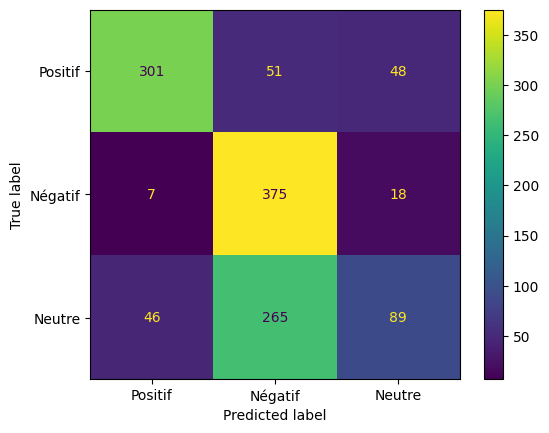

In [8]:
dtip_labels=bal_df["Ressenti usager"].values.tolist()
predicted_labels=bal_df["sentiment_eval"].values.tolist()
labels=["Positif","Négatif","Neutre"]

results=confusion_matrix(dtip_labels,predicted_labels,labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=results,display_labels=labels)
disp.plot()

# Topic modelling

In [9]:

stoplist=stopwords.words("french")
text_processing(df,"Description")
token_df,X_full = token_processing(df,stoplist=stoplist)

df.columns


Index(['ID expérience', 'Etat expérience', 'Statut de l'expérience',
       'Date de publication', 'Titre', 'Description', 'Posté comme',
       'Ressenti usager', 'Code INSEE Département usager',
       'Intitulé département usager', 'Intitulé région usager',
       'Code INSEE Région usager', 'Pays', 'Intitulé Typologie 1',
       'Code Postal typologie 1', 'Pays Typologie  1', 'Canaux Typologie 1',
       'Intitulé Typologie 2', 'Code Postal typologie 2', 'Pays Typologie 2',
       'Canaux Typologie 2', 'Intitulé Typologie 3', 'Code Postal typologie 3',
       'Pays Typologie 3', 'Canaux Typologie 3', 'Hors structure',
       'ID structure 1', 'Intitulé structure 1',
       'Evaluation utile réponse structure 1 par visiteurs',
       'Evaluation inutile réponse structure 1 par visiteurs',
       'Evaluation  réponse structure 1 par auteur', 'ID structure 2',
       'Intitulé structure 2', 'ID structure 3', 'Intitulé structure  3',
       'Accessibilité', 'Information/Explication', '

In [10]:
'''
for i in range(12, 20):
    corpus = token_df["desc_stem++"].tolist()
    dictionary = Dictionary(corpus)
    bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]
    lda_model = LdaModel(bow_corpus, num_topics=i, id2word=dictionary, passes=10)
    coherence_model = CoherenceModel(model=lda_model, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"For {i} components, the coherence score is: {coherence_score}")
'''    

'\nfor i in range(12, 20):\n    corpus = token_df["desc_stem++"].tolist()\n    dictionary = Dictionary(corpus)\n    bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]\n    lda_model = LdaModel(bow_corpus, num_topics=i, id2word=dictionary, passes=10)\n    coherence_model = CoherenceModel(model=lda_model, texts=corpus, dictionary=dictionary, coherence=\'c_v\')\n    coherence_score = coherence_model.get_coherence()\n    print(f"For {i} components, the coherence score is: {coherence_score}")\n'

# Etude des référentiels structures SP+

In [11]:
df["Intitulé structure 1"].value_counts()

Intitulé structure 1
Hors-structures                                                          2773
ANTS                                                                     1893
Direction des Français à l'étranger et de l'administration consulaire    1040
CARSAT Rhône-Alpes                                                        531
CNAM                                                                      431
                                                                         ... 
Service des Impôts des particuliers (SIP) MULHOUSE                          1
Ambassade de France en Birmanie                                             1
Préfecture de l'Aveyron                                                     1
CPAM PERIGUEUX                                                              1
Bibliothèque publique d'Information                                         1
Name: count, Length: 1117, dtype: int64

In [12]:
#str_df=pd.read_csv("export-structures.csv",delimiter=';',encoding='utf-8')

In [13]:
gend_df=str_df[str_df["Intitulé du réseau"]=="Gendarmerie Nationale"]

In [14]:
join_gend_df=pd.merge(gend_df,df,left_on='﻿"Code SP+ de la structure"',right_on="ID structure 1",how="inner")

In [15]:
gend_df_neg=join_gend_df[join_gend_df["Ressenti usager"]=='Négatif']

gend_df_neg=gend_df_neg.loc[:,["Description","Adresse","Intitulé de la structure"]]

gend_df_neg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 5 to 631
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Description               126 non-null    object
 1   Adresse                   126 non-null    object
 2   Intitulé de la structure  126 non-null    object
dtypes: object(3)
memory usage: 3.9+ KB


In [16]:
text_processing(gend_df_neg,"Description")

In [17]:
stoplist=stopwords.words("french")

my_sw=Sw([])
my_sw.add_sw(Sw.custom["month"])
my_sw.add_sw(Sw.custom["day"])
my_sw.add_sw(Sw.custom["tempo"])
my_sw.add_sw(Sw.custom["thing"])
my_sw.add_sw(Sw.custom["pron"])
my_sw.add_sw(Sw.custom["polite"])
my_sw.add_sw(Sw.custom["verb"])
my_sw.add_sw(Sw.custom["det"])
my_sw.add_sw(Sw.custom["adj"])
my_sw.add_sw(Sw.custom["subord"])
my_sw.add_sw(Sw.custom["prep"])
my_sw.add_sw(Sw.custom["adv"])
my_sw.add_sw(Sw.custom["neg"])
my_sw.add_sw(Sw.custom["gender"])
my_sw.add_sw(Sw.custom["subj"])
my_sw.add_sw(Sw.custom["conj"])

my_custom_list=["gendarmer","gendarm","elancourt","republ","mallemort","commissariat","uze","lamarch","darney","polic","plaint"]
my_sw.add_sw(my_custom_list)
buff_list=["port","telephon","plusieur","avant","suit","public","don",'accueil',"prend","demarch"]
buff_list+=["nombreux","voil","aucun","auss","lor","servic","jam","poul","demand","deux","mal","peu","trait"]
buff_list+=["all","alle","allez","aller","allais","allait","quel"]

'''
buff_list=["aim","ose","douleur","peu","chais","premier","lor","mond","ete","actuel","tas","lamarch","darney","concern","crois"]
buff_list+=["histoir","effectue","auss","selon","donc","region","deux","allait","allais","remettr","nez","chaqu","faudr","avant"]
buff_list+=["voulu","ecrit","ecris","plusieur","detail","meti","nombreux","cric","tre","accord","all","facon","cle","droit"]
buff_list+=["valoir","aucun","demarch","bras","fenetr","genr","bref","categor","pied","environ","allez","choix","demande","mal"]
buff_list+=["servic","telephon","demand","agent","public","moyen","port","pouv","clair","lign","appel"]

buff_list+=["plaint","polic","seul","procur","prend","accueil","attent","attend","refus","trouv","victim","depos","depot"]
buff_list+=["suivr","suit","voul","continu","util","efficac","trouvon","recu","indiqu","expliqu","arriv","sit","problem"]
buff_list+=["don","signal","dev","repons","aid","ver","vol","papi","part","sen","venu","ecoute","main","ecout","laiss","arret","tel"]


buff_list+=["vais","repond","present","voitur","aller","jam","attendr","vot","besoin","contr","question","inform","vi","vitesse"]
buff_list+=["just","societ","racont",'attendu','fin',"faut","pend","valid","ven","blainvill","entendu","alle","procureur"]
buff_list+=["pre","cour","impossibl","encor","proch","tour","epoqu","humain","probabl","mieux","dois","rend","fil"]
'''
my_sw.add_sw(buff_list)

token_gend_df,X_gend=token_processing(gend_df_neg,stoplist,stop_list_stemming=my_sw.sw_list)

In [18]:
model = BERTopic(nr_topics="5",verbose=True,language="French")
docs=gend_df_neg["desc_clean"].tolist()
topics, probabilities = model.fit_transform(docs)
model.get_topic_freq().head(11)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2023-06-01 09:42:10,817 - BERTopic - Transformed documents to Embeddings
2023-06-01 09:42:22,314 - BERTopic - Reduced dimensionality
2023-06-01 09:42:22,349 - BERTopic - Clustered reduced embeddings
2023-06-01 09:42:22,924 - BERTopic - Reduced number of topics from 4 to 4


,Topic,Count
0,0,46
1,1,40
2,-1,28
3,2,12


In [19]:
#find_best_LDA(token_gend_df,iterable=range(3,12))

In [20]:
#scrap_df=pd.read_csv("scrapping_gend.csv",delimiter=',',encoding="iso-8859-1")

In [21]:
scrap_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Index        295 non-null    int64 
 1   Adresse      295 non-null    object
 2   Auteur       295 non-null    object
 3   Date         295 non-null    object
 4   Note         295 non-null    int64 
 5   Commentaire  73 non-null     object
dtypes: int64(2), object(4)
memory usage: 14.0+ KB


In [22]:
scrap_df_neg=scrap_df[scrap_df["Note"]<=3]

In [23]:
filtered_df = scrap_df[scrap_df["Commentaire"].notnull()]

In [24]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 0 to 294
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Index        73 non-null     int64 
 1   Adresse      73 non-null     object
 2   Auteur       73 non-null     object
 3   Date         73 non-null     object
 4   Note         73 non-null     int64 
 5   Commentaire  73 non-null     object
dtypes: int64(2), object(4)
memory usage: 4.0+ KB


In [25]:
filtered_df_neg=filtered_df[filtered_df["Note"]<=3]
filtered_df_neg["Description"]=filtered_df_neg["Commentaire"]

In [26]:
filtered_df_neg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 1 to 294
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Index        35 non-null     int64 
 1   Adresse      35 non-null     object
 2   Auteur       35 non-null     object
 3   Date         35 non-null     object
 4   Note         35 non-null     int64 
 5   Commentaire  35 non-null     object
 6   Description  35 non-null     object
dtypes: int64(2), object(5)
memory usage: 2.2+ KB


In [27]:
gend_df_neg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 5 to 631
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Description               126 non-null    object
 1   Adresse                   126 non-null    object
 2   Intitulé de la structure  126 non-null    object
 3   desc                      126 non-null    object
 4   desc_clean                126 non-null    object
dtypes: object(5)
memory usage: 5.9+ KB


In [28]:
df_updated = pd.concat([gend_df_neg, filtered_df_neg], ignore_index=True)

In [29]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Description               161 non-null    object 
 1   Adresse                   161 non-null    object 
 2   Intitulé de la structure  126 non-null    object 
 3   desc                      126 non-null    object 
 4   desc_clean                126 non-null    object 
 5   Index                     35 non-null     float64
 6   Auteur                    35 non-null     object 
 7   Date                      35 non-null     object 
 8   Note                      35 non-null     float64
 9   Commentaire               35 non-null     object 
dtypes: float64(2), object(8)
memory usage: 12.7+ KB


In [30]:
text_processing(df_updated,"Description")

In [64]:
pd.options.display.max_rows = 100
#print(gend_df_neg["desc_clean"][:100])

my_sw.add_sw(["apre","rol","blainvill","quoi","cas","pourt","quil","dun","quoi","dois","indiqu","recu","problem","main","cour","promess"])


#my_sw.add_sw(["appel","problem","pouv","rol","expliqu","blainvill","attend","attendr","attendu","recepiss","quil","dun","encor","petit","difficil"])

#my_sw.add_sw(["coordonne","present","vi","possibl","indiqu","fin","ete","chaqu","franc","dois","dej","vacanc","plein","region"])

#my_sw.add_sw(["erreur","nouveau","seul","pourt","vais","different","attent","lign","seul","dev","inform","arriv","part"])

#my_sw.add_sw(["travail","agent","quoi","cour","cas","apparent","raison","pend","pouvoir","refusent","sujet","victim","nouvel","hont"])

In [65]:
token_df_augmented,X_gend_with_scrapping=token_processing(df_updated,stoplist=stoplist,stop_list_stemming=my_sw.sw_list)

In [68]:
model = BERTopic(nr_topics="6",verbose=True,language="French")
docs=df_updated["desc_clean"].tolist()
topics, probabilities = model.fit_transform(docs)
model.get_topic_freq().head(11)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

2023-06-01 09:47:43,647 - BERTopic - Transformed documents to Embeddings
2023-06-01 09:47:46,957 - BERTopic - Reduced dimensionality
2023-06-01 09:47:46,971 - BERTopic - Clustered reduced embeddings
2023-06-01 09:47:47,654 - BERTopic - Reduced number of topics from 5 to 5


,Topic,Count
0,0,52
1,-1,44
2,1,40
3,2,13
4,3,12


In [70]:
model.visualize_barchart()

In [35]:
model.visualize_heatmap()

In [36]:
model.save("my_topics_model_8")

In [72]:
topics_name=["refus_plainte","appel_intervention","perceval","procuration","autre"]
print(topics)

[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 1, 1, -1, 1, 1, 1, 0, -1, -1, 0, -1, -1, -1, 0, -1, 1, 0, 1, 0, -1, 0, 1, -1, 0, 0, -1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, -1, 2, 2, 2, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 3, -1, 3, -1, 1, -1, 0, -1, 0, 0, 0, 3, 1, 0, 0, 0, 0, -1, -1, -1, 1, 0, -1, 0, -1, 0, 0, -1, 0, 1, 0, -1, 0, 3, 3, 1, 0, 0, -1, 0, 1, 0, 3, 3, 0, -1, -1, 1, -1, -1, 3, -1, 0, 0, -1, 3, 1, 1, 1, 3, -1, 0, 1, 1, 1, 1, 1, 3, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 0, 0, 1, -1, 0, -1, 1, 1, 3, 1, 1, 1, -1, 2, 1, -1, 1]


In [74]:
df_updated['subject_number']=topics

df_updated['subject_name']=df_updated["subject_number"].apply(lambda x: topics_name[x])


0           refus_plainte
1           refus_plainte
2                   autre
3           refus_plainte
4           refus_plainte
              ...        
156                 autre
157              perceval
158    appel_intervention
159                 autre
160    appel_intervention
Name: subject_name, Length: 161, dtype: object

In [75]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Description               161 non-null    object 
 1   Adresse                   161 non-null    object 
 2   Intitulé de la structure  126 non-null    object 
 3   desc                      161 non-null    object 
 4   desc_clean                161 non-null    object 
 5   Index                     35 non-null     float64
 6   Auteur                    35 non-null     object 
 7   Date                      35 non-null     object 
 8   Note                      35 non-null     float64
 9   Commentaire               35 non-null     object 
 10  subject_number            161 non-null    int64  
 11  subject_name              161 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 15.2+ KB


In [77]:
df_updated["Adresse"].value_counts()

Adresse
85 Bd Clémenceau                                                              36
359 rue de Fontcouverte                                                       18
5, Boulevard de l’Hautil                                                      15
36 boulevard de l’Ouest                                                       11
Casere Battesti 59 rue Séguineau                                               9
4 Av Busteau                                                                   6
19 bis rue de la Mitrie                                                        5
201 Bd de Mons                                                                 4
162 Av de la Timone                                                            4
6 av de Stalingrad                                                             4
2 rue Abert Bettanier                                                          3
Gendarmerie Nationale place du Champ de Mars 7000 PRIVAS                       2
Gendarmerie National

In [78]:
df_updated.to_csv("gend_topic.csv",sep=";")

# Cas de la DGFIP

In [40]:
dgfip_df=str_df[str_df["Intitulé du réseau"]=="DGFIP"]

In [41]:
dgfip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3419 entries, 32 to 14166
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ﻿"Code SP+ de la structure"       3419 non-null   object 
 1   Intitulé du réseau                3419 non-null   object 
 2   Intitulé de la typologie          3419 non-null   object 
 3   Intitulé de la structure          3419 non-null   object 
 4   Intitulé structure usager         1 non-null      object 
 5   Description de la structure       3418 non-null   object 
 6   Identifiant de la structure       3408 non-null   object 
 7   Type d'identifiant                3408 non-null   object 
 8   Code SP+ structure parent         3418 non-null   object 
 9   Intitulé de la structure parente  3418 non-null   object 
 10  Adresse                           0 non-null      object 
 11  Compléments Adresse               0 non-null      object 
 12  Code post

In [42]:
dgfip_df=str_df[str_df["Intitulé du réseau"]=="DGFIP"]
join_dgfip_df=pd.merge(dgfip_df,df,left_on='﻿"Code SP+ de la structure"',right_on="ID structure 1",how="inner")


In [43]:
dgfip_df_neg=join_dgfip_df[join_dgfip_df["Ressenti usager"]=='Négatif']

dgfip_df_neg=dgfip_df_neg.loc[:,["Description","Adresse","Intitulé de la structure"]]

dgfip_df_neg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 972 entries, 0 to 1279
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Description               972 non-null    object
 1   Adresse                   0 non-null      object
 2   Intitulé de la structure  972 non-null    object
dtypes: object(3)
memory usage: 30.4+ KB


In [44]:
text_processing(dgfip_df_neg,"Description")

In [45]:
dgfip_df_neg["desc"]

0       nous avons pas television mais tous les ans no...
1       sans trop rentrer dans les details apres moult...
2       suis actuellement chine veux acceder page decl...
3       bonjourje vis etranger dois effectuer premiere...
4       imposition non residents questions par email s...
                              ...                        
1275    bonjour design president conseil syndical mon ...
1276    bonjour sie bombarde saint german laval nous e...
1277    bonjour permets vous informer manque certain r...
1278    jour toujours recu aucune information part tre...
1279    bonjour ayant signal aux services des impots c...
Name: desc, Length: 972, dtype: object

In [46]:
sw_dgfip=Sw([])
sw_dgfip.add_sw(Sw.custom["month"])
sw_dgfip.add_sw(Sw.custom["day"])
sw_dgfip.add_sw(Sw.custom["tempo"])
sw_dgfip.add_sw(Sw.custom["thing"])
sw_dgfip.add_sw(Sw.custom["pron"])
sw_dgfip.add_sw(Sw.custom["polite"])
sw_dgfip.add_sw(Sw.custom["verb"])
sw_dgfip.add_sw(Sw.custom["det"])
sw_dgfip.add_sw(Sw.custom["adj"])
sw_dgfip.add_sw(Sw.custom["subord"])
sw_dgfip.add_sw(Sw.custom["prep"])
sw_dgfip.add_sw(Sw.custom["adv"])
sw_dgfip.add_sw(Sw.custom["neg"])
sw_dgfip.add_sw(Sw.custom["gender"])
sw_dgfip.add_sw(Sw.custom["subj"])
sw_dgfip.add_sw(Sw.custom["conj"])

sw_dgfip.add_sw(["franc","francai","pari","impot","problem","faut","demand","servic","expliqu","pai","pay","euros","lign","possibl","impossibl"])

sw_dgfip.add_sw(["declar","recu"])


In [47]:
token_dgfip,X_dgfip=token_processing(dgfip_df_neg,stoplist=stoplist,stop_list_stemming=sw_dgfip.sw_list,verbose=True,nb_occurence=2)

################################################################
Counter({'sit': 349, 'telephon': 313, 'repons': 309, 'aucun': 293, 'compt': 285, 'amend': 270, 'mail': 249, 'tax': 235, 'apre': 219, 'contact': 213, 'appel': 202, 'administr': 183, 'centr': 183, 'numero': 181, 'adress': 181, 'cas': 179, 'courri': 179, 'prelev': 177, 'fiscal': 176, 'trouv': 174, 'gouv': 166, 'pass': 160, 'revenus': 159, 'regl': 159, 'erreur': 157, 'indiqu': 154, 'messag': 153, 'inform': 152, 'part': 135, 'aid': 133, 'rempl': 132, 'jam': 130, 'seul': 127, 'joindr': 125, 'habit': 124, 'question': 121, 'docu': 117, 'public': 116, 'internet': 115, 'concern': 112, 'plusieur': 112, 'simpl': 110, 'envoi': 108, 'don': 108, 'chang': 106, 'messager': 100, 'fin': 100, 'encor': 100, 'agent': 100, 'demarch': 98, 'del': 98, 'repond': 97, 'envoy': 96, 'mont': 96, 'foncier': 95, 'deux': 93, 'espac': 92, 'dat': 91, 'formulair': 91, 'imposit': 88, 'pag': 87, 'attent': 87, 'major': 86, 'relanc': 86, 'arriv': 85, 'rend': 85, 

In [48]:
model,topics,probabilities=use_BerTopic_model(dgfip_df_neg)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

2023-06-01 09:43:59,031 - BERTopic - Transformed documents to Embeddings
2023-06-01 09:44:04,510 - BERTopic - Reduced dimensionality
2023-06-01 09:44:04,581 - BERTopic - Clustered reduced embeddings
2023-06-01 09:44:05,622 - BERTopic - Reduced number of topics from 7 to 7


   Topic  Count
0      0    341
1      1    249
2     -1    224
3      2     68
4      3     54
5      4     21
6      5     15


In [49]:
model.visualize_barchart()

In [50]:
model.visualize_heatmap()

In [51]:
model.visualize_topics()

In [52]:
dgfip_df_neg["desc"]

0       nous avons pas television mais tous les ans no...
1       sans trop rentrer dans les details apres moult...
2       suis actuellement chine veux acceder page decl...
3       bonjourje vis etranger dois effectuer premiere...
4       imposition non residents questions par email s...
                              ...                        
1275    bonjour design president conseil syndical mon ...
1276    bonjour sie bombarde saint german laval nous e...
1277    bonjour permets vous informer manque certain r...
1278    jour toujours recu aucune information part tre...
1279    bonjour ayant signal aux services des impots c...
Name: desc, Length: 972, dtype: object

In [53]:
dgfip_df_neg["prlvt_source"]=dgfip_df_neg["desc"].apply(lambda x: "Oui" if "prelevement" and "source" in x else "Non")

In [54]:
dgfip_df_neg["amende"]=dgfip_df_neg["desc"].apply(lambda x: "Oui" if "amende" in x else "Non")

In [55]:
dgfip_df_neg["amende"].value_counts()

amende
Non    845
Oui    127
Name: count, dtype: int64

In [56]:
dgfip_df_neg["desc"][dgfip_df_neg["amende"]=="Oui"]

7       suite une amende stationnement percue mois jui...
10      date fais objet une saisie pour atd amendes po...
133     resident etranger conjoint agent diplomatique ...
134     passons sur les conditions application fps con...
135     bonjour conduisais scooter mon fils paris verb...
                              ...                        
1227    suis retrouvee deux reprises devoir regler des...
1230    cre societ sur site inpi arrive pas avoir mon ...
1241    bonjour mars confie voiture garage citroen voi...
1253    achete une voiture neuve garage reprend mon an...
1274    bonjour service tresorerie amendes rouen injoi...
Name: desc, Length: 127, dtype: object

In [57]:
dgfip_df_neg["telephone"]=dgfip_df_neg["desc"].apply(lambda x: "Oui" if "telephone" in x else "Non")

In [58]:
dgfip_df_neg["telephone"].value_counts()

telephone
Non    767
Oui    205
Name: count, dtype: int64

In [59]:
dgfip_df_neg_tel=dgfip_df_neg[dgfip_df_neg["telephone"]=="Oui"]

In [60]:
dgfip_df_neg_tel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 3 to 1275
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Description               205 non-null    object
 1   Adresse                   0 non-null      object
 2   Intitulé de la structure  205 non-null    object
 3   desc                      205 non-null    object
 4   desc_clean                205 non-null    object
 5   prlvt_source              205 non-null    object
 6   amende                    205 non-null    object
 7   telephone                 205 non-null    object
dtypes: object(8)
memory usage: 14.4+ KB


In [61]:
from sklearn.decomposition import PCA

In [62]:
print(X_dgfip)

  (0, 336)	0.22865844160938104
  (0, 1507)	0.35910261187699893
  (0, 478)	0.30831219104671764
  (0, 1587)	0.2764290014149682
  (0, 234)	0.26963246273267916
  (0, 1742)	0.258720978343748
  (0, 1446)	0.456928882482432
  (0, 1750)	0.5466891420281756
  (1, 1885)	0.15982575046858002
  (1, 1857)	0.18855629494737494
  (1, 257)	0.1500408726434747
  (1, 400)	0.1367557407828335
  (1, 852)	0.14540583348589944
  (1, 1583)	0.15552296040304253
  (1, 754)	0.09105725998994456
  (1, 33)	0.08901410339094652
  (1, 627)	0.13274068723734286
  (1, 1140)	0.15982575046858002
  (1, 1238)	0.17843916803023185
  (1, 1574)	0.13004620762176808
  (1, 932)	0.15982575046858002
  (1, 530)	0.12316534501203176
  (1, 1233)	0.09082326474763297
  (1, 959)	0.09480503855880365
  (1, 962)	0.18855629494737494
  :	:
  (971, 383)	0.11259992522038312
  (971, 623)	0.1305510717405784
  (971, 577)	0.12703640747099895
  (971, 17)	0.1084270771863061
  (971, 1565)	0.09846854939727863
  (971, 1302)	0.11997071955944671
  (971, 292)	0.1225

In [63]:
find_best_LDA(token_dgfip)

For 5 components, the coherence score_cv is: 0.3556306718436082
For 5 components, the coherence score_umass is: -1.4653189486904281
For 5 components, the coherence score_cnpmi is: -0.001104013426066795


For 6 components, the coherence score_cv is: 0.3605571920252435
For 6 components, the coherence score_umass is: -1.506567070255989
For 6 components, the coherence score_cnpmi is: -5.688352203839968e-05


For 7 components, the coherence score_cv is: 0.32623965045829084
For 7 components, the coherence score_umass is: -1.4695161921399402
For 7 components, the coherence score_cnpmi is: -0.010232646958385173


For 8 components, the coherence score_cv is: 0.3336596405524188
For 8 components, the coherence score_umass is: -1.5019917078841216
For 8 components, the coherence score_cnpmi is: -0.009144609929463934


For 9 components, the coherence score_cv is: 0.32672772122741506
For 9 components, the coherence score_umass is: -1.5853837494241103
For 9 components, the coherence score_cnpmi is: -0